### Import Packages


In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm
from collections import OrderedDict


import matplotlib.pyplot as plt
# Module for Google Drivefrom google.colab import drive

# Module for Importing Images
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.10.0+cu111


In [29]:
!pip3 list


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package               Version
--------------------- -------------------
asn1crypto            0.24.0
attrs                 17.4.0
Automat               0.6.0
bleach                2.1.2
blinker               1.4
boto                  2.44.0
certifi               2018.1.18
chardet               3.0.4
click                 6.7
cloud-init            18.2
colorama              0.3.7
command-not-found     0.3
configobj             5.0.6
constantly            15.1.0
cryptography          2.1.4
cycler                0.11.0
dataclasses           0.8
decorator             4.1.2
distro-info           0.18ubuntu0.18.04.1
entrypoints           0.2.3.post1
google-compute-engine 2.7.5
html5lib              0.999999999
httplib2              0.9.2
hyperlink             17.3.1
idna                  2.6
incremental       

In [2]:
torch.cuda.is_available()

True

### Import your drive's contents!

In [ ]:
#drive.mount('/content/drive')

Mounted at /content/drive


### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [63]:
train_path = '/home/weixing/pokemon/data/pokemon-extend/train' 
val_path = '/home/weixing/pokemon/data/pokemon-extend/test'
model_dir = '/home/weixing/pokemon/models'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [64]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.preprocess = torchvision.transforms.Compose([
                torchvision.transforms.Resize((244,224)),
                torchvision.transforms.CenterCrop((224,224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        # make sure all images have 3 layers
        img = Image.open(fp).convert('RGB')
        # torchvision.transform.Resize does not work for some reason
        img = img.resize((224,224))
        original_img = self.tensor_transform(img)
        input_img = self.preprocess(img)

        sample = dict()
        sample['input'] = input_img
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Set DataSet and DataLoader

In [67]:
batch_size = 32

train_dataset = PokemonDataset(train_path, classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = PokemonDataset(val_path, classes)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(classes)

### Take a sample and try to look at the one

In [59]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


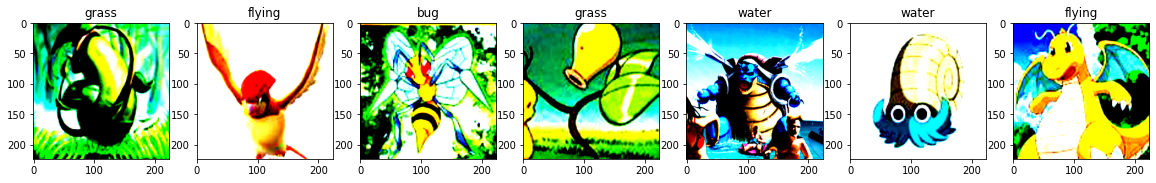

In [60]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Define the model with the pre-trained ResNet

In [7]:
def load_checkpoint(model,filepath):
    if os.path.isfile(filepath):
        print("=> loading checkpoint '{}'".format(filepath))
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['state_dict'])

    return model

In [70]:
class Model(nn.Module):
    def __init__(self, feat_dim = 2048, output_dim =num_classes,cppath = None):
        super(Model, self).__init__()
        self.cppath = cppath
        self.feat_dim = feat_dim
        self.output_dim = output_dim

        self.backbone = torchvision.models.__dict__["resnet50"](pretrained=True)
        
        #
        # add dataparallel to resolve state_dict key conflict
        #self.backbone = nn.DataParallel(self.backbone, device_ids=[0])
        
        #alternative: 
        if self.cppath:
            print("=> loading checkpoint '{}'".format(cppath))
            checkpoint = torch.load(cppath)
            state_dict = OrderedDict()
            for key in checkpoint['state_dict'].keys():
                state_dict[key[7:]] = checkpoint['state_dict'][key]
            self.backbone.load_state_dict(state_dict)
        
        #I have to train the whole neural net
        #for param in self.backbone.parameters():
        #    param.requires_grad = False

        self.backbone.fc = nn.Linear(feat_dim, output_dim)
        #for param in self.backbone.fc.parameters():
        #    param.requires_grad =True
            
    def _load_checkpoint(self,model):
        if os.path.isfile(filepath):
            print("=> loading checkpoint '{}'".format(filepath))
            checkpoint = torch.load(filepath)
            model.load_state_dict(checkpoint['state_dict'])

        return model

    def forward(self, img):
        out = self.backbone(img) 
        return out

### Create a model and its optimizer


In [72]:
# use pretrained model
# see https://github.com/hendrycks/imagenet-r

model = Model(cppath="/home/weixing/pokemon/models/deepaugment_and_augmix.pth.tar")
model = model.to(device)

optimizer = optim.NAdam(model.parameters(), lr=1e-3)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

=> loading checkpoint '/home/weixing/pokemon/models/deepaugment_and_augmix.pth.tar'


In [36]:
model(sample['input'].to(device)).shape

torch.Size([12, 1000])

### Define functions for train/test



In [10]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [11]:
def val(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training

In [73]:
max_epoch = 10
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1
#create checkpoint folder
from datetime import datetime
today = datetime.now()
checkpoint_path =os.path.join(model_dir,today.strftime('%Y%m%d'))
from pathlib import Path
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

p_train_loss = []
p_train_acc = []
p_val_loss = []
p_val_loss = []



for epoch in range(max_epoch):        
    ###Train Phase
    print('Epoch {}/{}'.format(epoch, max_epoch - 1))
    print('current learning rate:'.format(exp_lr_scheduler.get_lr()))
    print('-' * 10)
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0
    

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)
    #schedule training lr
    exp_lr_scheduler.step()

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(val_dataloader):
        curr_loss, num_correct = val(model, sample)
        test_loss += curr_loss / len(val_dataloader)
        test_accu += num_correct / len(val_dataset)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_best.pth'))

    print("train_acc:{}, val_acc{}".format(train_accu, test_accu))
    

Epoch 0/9
current learning rate:
----------


/home/weixing/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.719956379498365, val_acc0.4
Epoch 1/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.8841875681570346, val_acc0.48333333333333334
Epoch 2/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.959651035986913, val_acc0.8500000000000001
Epoch 3/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9901853871319515, val_acc0.9
Epoch 4/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9949836423118863, val_acc0.8833333333333333
Epoch 5/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9958560523446018, val_acc0.9
Epoch 6/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9971646673936747, val_acc0.8666666666666667
Epoch 7/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9958560523446018, val_acc0.8500000000000001
Epoch 8/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9956379498364227, val_acc0.8833333333333333
Epoch 9/9
current learning rate:
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train_acc:0.9956379498364228, val_acc0.8833333333333333


# Test

In [86]:
checkpoint_path = '/home/weixing/pokemon/models/20211216'
test_model_path = os.path.join(checkpoint_path,'pokemon_r50_best.pth')
test_path = '/home/weixing/pokemon/data/test'


In [83]:
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [84]:
checkpoint = torch.load(test_model_path)
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [80]:
def test(model, sample):
    model.eval()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return num_correct.item()

In [85]:
test_accu = 0.0

# Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar:
    for idx, sample in enumerate(test_dataloader):
        num_correct = test(model, sample)
        test_accu += num_correct / len(test_dataloader)
        pbar.update(1)

print('Total Accuracy: ', test_accu)

Widget Javascript not detected.  It may not be installed or enabled properly.



Total Accuracy:  0.9000000000000011
